# Article Relevance Prediction for NeotomaDB

This notebook contains the following tasks:
1. Extract CrossRef metadata of articles that currently exist in NeotomaDB (positive cases)
2. Data cleaning and saved as json file
3. Extract CrossRef metadata of articles that do not exist in NeotomaDB (negative cases)
4. Data cleaning and saved as json file
5. Create train test dataset
6. Baseline model: logistic regression with BOW features


### Imports

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
pd.set_option("display.max_colwidth", 200)

## 1. Extract CrossRef Metadata for Articles in NeotomaDB

The neotoma.csv file is provided by our partner. 

It contains 6889 site records from 2316 sites.

The csv file contains data contributed from 758 distinct articles. 

Note that only 244 of these articles has abstract.

In [25]:
import requests
import json
import os

In [26]:
# load csv
neotoma = pd.read_csv("../data/hackathon_data/neotoma_crossref_fixed.csv").iloc[:, 0:-2]
neotoma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6889 entries, 0 to 6888
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   siteid             6889 non-null   int64  
 1   sitename           6889 non-null   object 
 2   longitudeeast      6889 non-null   float64
 3   latitudenorth      6889 non-null   float64
 4   longitudewest      6889 non-null   float64
 5   latitudesouth      6889 non-null   float64
 6   altitude           4925 non-null   float64
 7   area               2176 non-null   float64
 8   sitedescription    5525 non-null   object 
 9   notes              2361 non-null   object 
 10  recdatecreated     6889 non-null   object 
 11  recdatemodified    6889 non-null   object 
 12  geog               6889 non-null   object 
 13  datasetid          6889 non-null   object 
 14  collectionunitid   6889 non-null   int64  
 15  datasettypeid      6889 non-null   int64  
 16  datasetname        3442 

In [27]:
neotoma['doi'].value_counts()

10.1002/jqs.1114                   428
10.2307/1551050                    335
10.1023/A:1021675225099            301
10.1002/jqs.2584                   232
10.1016/j.quaint.2013.05.054       203
                                  ... 
10.1139/b69-192                      1
10.1016/j.quascirev.2009.09.005      1
10.1016/0034-6667(75)90040-8         1
10.2307/1942662                      1
10.1016/0033-5894(89)90098-7         1
Name: doi, Length: 758, dtype: int64

In [28]:
neotoma['sitename'].value_counts()

Moidach More                                       150
Minden Bog                                          96
South Rhody peatland                                69
Mukhrino Mire Complex                               68
Mer Bleue Bog                                       65
                                                  ... 
Station 25 (Lichti-Federovich and Ritchie 1968)      1
Station 22 (Lichti-Federovich and Ritchie 1968)      1
Station 21 (Lichti-Federovich and Ritchie 1968)      1
Station 20 (Lichti-Federovich and Ritchie 1968)      1
Hungry Jack Lake                                     1
Name: sitename, Length: 2316, dtype: int64

### 8 DOI Not Found, Replaced

In [29]:
# dot_status_df = pd.DataFrame(doi_status)
# dot_status_df.query("status_code == 404")['doi'].to_list()

In [30]:
doi_replace = {
    '10.2307/1551601\xa0 ' : '10.2307/1551601',
    '10.2307/1551050\xa0 ' : '10.2307/1551050',
    '10.1016/j.revpalbo.2004.09.004\xa0 ': '10.1016/j.revpalbo.2004.09.004',
    '10.1016/j.quascirev.2016.09.023.' : '10.1016/j.quascirev.2016.09.023',
    'Widga, C., S.N. Lengyel, J. Saunders, G. Hodgins, J.D. Walker, and A.D. Wanamaker. 2017. Late Pleistocene proboscidean population dynamics in the North American Midcontinent. Boreas 46(4):772-782. [DOI: 10.1111/bor.12235]': '10.1111/bor.12235',
    "Fiedel, S.J. 2018. The spore conundrum: Does a dung fungus decline signal humans' arrival in the Eastern United States?. Quaternary International 466:247e255. [DOI: doi.org/10.1016/j.quaint.2015.11.130]": '10.1016/j.quaint.2015.11.130',
    'Joyce, D.J. 2006. Chronology and new research on the Schaefer mammoth (? Mammuthus primigenius) site, Kenosha County, Wisconsin, USA,. Quaternary International 142:44-57. [DOI: doi:10.1016/j.quaint.2005.03.004]': '10.1016/j.quaint.2005.03.004',
    'Overstreet, D.F., and M.F. Kolb. 2003. Geoarchaeological contexts for Late Pleistocene archaeological sites with human‐modified woolly mammoth remains in southeastern Wisconsin, USA. Geoarchaeology 18(1):91-114. [DOI: DOI:10.1002/gea.10052]': '10.1002/gea.10052'
}
neotoma['doi'].replace(to_replace=doi_replace, inplace=True)

### Download metadata from CrossRef

In [31]:
# # Query Metadata from DOI
# doi_list = neotoma['doi'].unique().tolist()
# # testing purpose: take the first 10
# # input_doi = doi_list
# input_doi = doi_list

# doi_status = {}
# doi_status['doi'] = input_doi
# doi_status['status_code'] = []

# for doi in input_doi:
#     cross_ref_url = f"https://api.crossref.org/works/{doi}"

#     # make a request to the API
#     cross_ref_response = requests.get(cross_ref_url)

#     doi_status['status_code'].append(cross_ref_response.status_code)

#     if cross_ref_response.status_code == 200:

#         # save data
#         ref_data = cross_ref_response.json()
        
#         # create the directory if it doesn't exist 
#         directory = '../data/raw/crossref'
#         if not os.path.exists(directory):
#             os.makedirs(directory)

#         # save the JSON data to a file
#         doi_clean = doi.replace("/", "_")
#         filename = f'crossref_{doi_clean}.json'
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'w') as outfile:
#             json.dump(ref_data, outfile)

#     else:
#         print("DOI not found:", doi, "status_code", cross_ref_response.status_code)

### Positive Cases CrossRef Data Import

In [32]:
# Set the directory path
directory_path = "../data/raw/crossref/positive/"
# Get a list of all files and directories in the directory
files_and_directories = os.listdir(directory_path)
# Filter out the directories to get only the files
files = [file for file in files_and_directories if os.path.isfile(os.path.join(directory_path, file))]
if '.DS_Store' in files:
    files.remove('.DS_Store')
len(files)

757

In [33]:
# initialize empty dataframe
neotoma_crossref_df = pd.DataFrame()

# Populate the cross ref df
for f in files:
    file_path = f"../data/raw/crossref/positive/{f}"
    onefile = pd.read_json(file_path)
    onefile = pd.DataFrame(onefile.loc[:, 'message']).T.reset_index()
    
    # merge
    neotoma_crossref_df = pd.concat([neotoma_crossref_df, onefile])

neotoma_crossref_df["target"] = 1

neotoma_crossref_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 0 to 0
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   757 non-null    object
 1   DOI                     757 non-null    object
 2   ISSN                    745 non-null    object
 3   URL                     757 non-null    object
 4   alternative-id          598 non-null    object
 5   author                  751 non-null    object
 6   container-title         757 non-null    object
 7   content-domain          757 non-null    object
 8   created                 757 non-null    object
 9   deposited               757 non-null    object
 10  indexed                 757 non-null    object
 11  is-referenced-by-count  757 non-null    object
 12  issn-type               745 non-null    object
 13  issue                   673 non-null    object
 14  issued                  757 non-null    object
 15  journal-

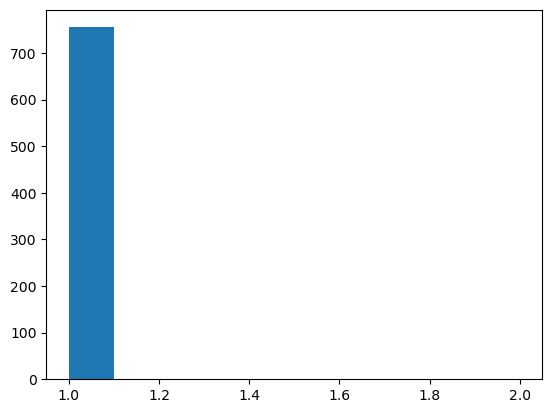

In [34]:
counts = neotoma_crossref_df['DOI'].value_counts()
plt.hist(counts)
plt.show()

### Negative Cases CrossRef Data Import

#### Sample code to search GDD

In [35]:
# #term to search GeoDeepDive
# term = "Animal"
# # Number of articles to return
# n = 100

# response = requests.get("https://geodeepdive.org/api/articles?term=" + term + "&max=" + str(n) + "&type=journal-article")
# if cross_ref_response.status_code == 200:

#         # save data
#         ref_data = response.json()
        
#         # create the directory if it doesn't exist 
#         directory = '../data/raw/negative'
#         if not os.path.exists(directory):
#             os.makedirs(directory)

#         # save the JSON data to a file
#         doi_clean = doi.replace("/", "_")
#         filename = f'crossref_{doi_clean}.json'
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'w') as outfile:
#             json.dump(ref_data, outfile)

# else:
#     print("DOI not found:", doi, "status_code", cross_ref_response.status_code)

In [36]:
# Set the directory path
directory_path = "../data/raw/crossref/negative/"
# Get a list of all files and directories in the directory
files_and_directories = os.listdir(directory_path)
# Filter out the directories to get only the files
files = [file for file in files_and_directories if os.path.isfile(os.path.join(directory_path, file))]
if '.DS_Store' in files:
    files.remove('.DS_Store')
len(files)

1786

In [37]:
# initialize empty dataframe
negative_crossref_df = pd.DataFrame()

# Populate the cross ref df
for f in files:
    file_path = f"../data/raw/crossref/negative/{f}"
    onefile = pd.read_json(file_path)
    onefile = pd.DataFrame(onefile.loc[:, 'message']).T.reset_index()
    
    # merge
    negative_crossref_df = pd.concat([negative_crossref_df, onefile])
negative_crossref_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 0
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   1786 non-null   object
 1   DOI                     1786 non-null   object
 2   ISSN                    1784 non-null   object
 3   URL                     1786 non-null   object
 4   archive                 475 non-null    object
 5   author                  1335 non-null   object
 6   container-title         1786 non-null   object
 7   content-domain          1786 non-null   object
 8   created                 1786 non-null   object
 9   deposited               1786 non-null   object
 10  indexed                 1786 non-null   object
 11  is-referenced-by-count  1786 non-null   object
 12  issn-type               1784 non-null   object
 13  issue                   1501 non-null   object
 14  issued                  1786 non-null   object
 15  journal

In [38]:
negative_crossref_df.head(3)

,index,DOI,ISSN,URL,archive,author,container-title,content-domain,created,deposited,...,volume,alternative-id,assertion,funder,update-policy,abstract,editor,published-other,update-to,article-number
0,message,10.1002/chin.201507318,[0931-7597],http://dx.doi.org/10.1002/chin.201507318,[Portico],"[{'given': 'Kristof', 'family': 'Kranjc', 'sequence': 'first', 'affiliation': []}, {'given': 'Marijan Koc', 'family': 'evar', 'sequence': 'additional', 'affiliation': []}]",[ChemInform],"{'domain': [], 'crossmark-restriction': False}","{'date-parts': [[2015, 1, 29]], 'date-time': '2015-01-29T10:38:37Z', 'timestamp': 1422527917000}","{'date-parts': [[2021, 7, 2]], 'date-time': '2021-07-02T09:01:39Z', 'timestamp': 1625216499000}",...,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,message,10.1002/chem.201590048,[0947-6539],http://dx.doi.org/10.1002/chem.201590048,NaN,"[{'given': 'Jin-Long', 'family': 'Wang', 'sequence': 'first', 'affiliation': []}, {'given': 'Jian-Wei', 'family': 'Liu', 'sequence': 'additional', 'affiliation': []}, {'given': 'Bing-Zhang', 'fami...",[Chemistry - A European Journal],"{'domain': [], 'crossmark-restriction': False}","{'date-parts': [[2015, 3, 12]], 'date-time': '2015-03-12T19:27:18Z', 'timestamp': 1426188438000}","{'date-parts': [[2021, 7, 3]], 'date-time': '2021-07-03T01:59:45Z', 'timestamp': 1625277585000}",...,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,message,10.1080/13698575.2015.1031645,"[1369-8575, 1469-8331]",http://dx.doi.org/10.1080/13698575.2015.1031645,NaN,"[{'given': 'Davina', 'family': 'Lohm', 'sequence': 'first', 'affiliation': []}, {'given': 'Mark', 'family': 'Davis', 'sequence': 'additional', 'affiliation': []}, {'given': 'Paul', 'family': 'Flow...","[Health, Risk &amp; Society]","{'domain': ['www.tandfonline.com'], 'crossmark-restriction': True}","{'date-parts': [[2015, 4, 15]], 'date-time': '2015-04-15T12:23:23Z', 'timestamp': 1429100603000}","{'date-parts': [[2017, 6, 23]], 'date-time': '2017-06-23T05:27:18Z', 'timestamp': 1498195638000}",...,17,[10.1080/13698575.2015.1031645],"[{'value': 'The publishing and review policy for this title is described in its Aims & Scope.', 'order': 1, 'name': 'peerreview_statement', 'label': 'Peer Review Statement'}, {'value': 'http://www...","[{'name': 'Australia Research Council Discovery Project', 'award': ['DP11010181']}]",http://dx.doi.org/10.1080/tandf_crossmark_01,NaN,NaN,NaN,NaN,NaN


In [39]:
negative_crossref_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 0
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   1786 non-null   object
 1   DOI                     1786 non-null   object
 2   ISSN                    1784 non-null   object
 3   URL                     1786 non-null   object
 4   archive                 475 non-null    object
 5   author                  1335 non-null   object
 6   container-title         1786 non-null   object
 7   content-domain          1786 non-null   object
 8   created                 1786 non-null   object
 9   deposited               1786 non-null   object
 10  indexed                 1786 non-null   object
 11  is-referenced-by-count  1786 non-null   object
 12  issn-type               1784 non-null   object
 13  issue                   1501 non-null   object
 14  issued                  1786 non-null   object
 15  journal

In [40]:
#Setting target column
negative_crossref_df["target"] = 0
negative_crossref_df.head(3)

,index,DOI,ISSN,URL,archive,author,container-title,content-domain,created,deposited,...,alternative-id,assertion,funder,update-policy,abstract,editor,published-other,update-to,article-number,target
0,message,10.1002/chin.201507318,[0931-7597],http://dx.doi.org/10.1002/chin.201507318,[Portico],"[{'given': 'Kristof', 'family': 'Kranjc', 'sequence': 'first', 'affiliation': []}, {'given': 'Marijan Koc', 'family': 'evar', 'sequence': 'additional', 'affiliation': []}]",[ChemInform],"{'domain': [], 'crossmark-restriction': False}","{'date-parts': [[2015, 1, 29]], 'date-time': '2015-01-29T10:38:37Z', 'timestamp': 1422527917000}","{'date-parts': [[2021, 7, 2]], 'date-time': '2021-07-02T09:01:39Z', 'timestamp': 1625216499000}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
0,message,10.1002/chem.201590048,[0947-6539],http://dx.doi.org/10.1002/chem.201590048,NaN,"[{'given': 'Jin-Long', 'family': 'Wang', 'sequence': 'first', 'affiliation': []}, {'given': 'Jian-Wei', 'family': 'Liu', 'sequence': 'additional', 'affiliation': []}, {'given': 'Bing-Zhang', 'fami...",[Chemistry - A European Journal],"{'domain': [], 'crossmark-restriction': False}","{'date-parts': [[2015, 3, 12]], 'date-time': '2015-03-12T19:27:18Z', 'timestamp': 1426188438000}","{'date-parts': [[2021, 7, 3]], 'date-time': '2021-07-03T01:59:45Z', 'timestamp': 1625277585000}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
0,message,10.1080/13698575.2015.1031645,"[1369-8575, 1469-8331]",http://dx.doi.org/10.1080/13698575.2015.1031645,NaN,"[{'given': 'Davina', 'family': 'Lohm', 'sequence': 'first', 'affiliation': []}, {'given': 'Mark', 'family': 'Davis', 'sequence': 'additional', 'affiliation': []}, {'given': 'Paul', 'family': 'Flow...","[Health, Risk &amp; Society]","{'domain': ['www.tandfonline.com'], 'crossmark-restriction': True}","{'date-parts': [[2015, 4, 15]], 'date-time': '2015-04-15T12:23:23Z', 'timestamp': 1429100603000}","{'date-parts': [[2017, 6, 23]], 'date-time': '2017-06-23T05:27:18Z', 'timestamp': 1498195638000}",...,[10.1080/13698575.2015.1031645],"[{'value': 'The publishing and review policy for this title is described in its Aims & Scope.', 'order': 1, 'name': 'peerreview_statement', 'label': 'Peer Review Statement'}, {'value': 'http://www...","[{'name': 'Australia Research Council Discovery Project', 'award': ['DP11010181']}]",http://dx.doi.org/10.1080/tandf_crossmark_01,NaN,NaN,NaN,NaN,NaN,0


### Combine the dataframes & Initial Variable Selection

In [41]:
combined_metadata_df = pd.concat([neotoma_crossref_df, negative_crossref_df])

crossref_keep_col = ['DOI',
 'URL',
 'abstract',
 'author',
 'container-title',
 'is-referenced-by-count', # times cited
 'language',
 'published', # datetime
 'publisher', 
 'subject', # keywords
 'subtitle', # subtitle are missing sometimes
 'title', # article title
 'target'
 ]

metadata_df = combined_metadata_df.loc[:, crossref_keep_col]


## 2. Data Wrangling - Tidy Data Columns

In [42]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2543 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DOI                     2543 non-null   object
 1   URL                     2543 non-null   object
 2   abstract                255 non-null    object
 3   author                  2086 non-null   object
 4   container-title         2543 non-null   object
 5   is-referenced-by-count  2543 non-null   object
 6   language                2452 non-null   object
 7   published               2542 non-null   object
 8   publisher               2539 non-null   object
 9   subject                 2480 non-null   object
 10  subtitle                2543 non-null   object
 11  title                   2543 non-null   object
 12  target                  2543 non-null   int64 
dtypes: int64(1), object(12)
memory usage: 278.1+ KB


In [43]:
# Reset index after concatenation
metadata_df = metadata_df.reset_index().drop('index', axis = 1)
metadata_df.head()
metadata_df.index

RangeIndex(start=0, stop=2543, step=1)

| Variable | Description | Preprocessing |
| --- | --- | --- |
| DOI | Digital Object Identifier | Temporarily keep it as primary ID. Will drop it during training. |
| URL | Link to the article | Temporarily keep it in case we need to look into the article. Will drop it during training.|
|abstract | Abstract of the article. Only 244 NeotomaDB articles has it. | Convert to Bag of Words representation|
|author | Author of the article | Consider droping due to duplicate names and various format and spelling |
|container-title | Title of the article's container | Keep as a categorical feature. Apply one-hot encoding|
| content-domain | The publisher's url. | Drop|
| short-container-title | Abbreviated title of the article's container. |Drop since it duplicates the information in container-title|
| is-referenced-by-count| Count of the article being referenced by other article | Keep as a numeric feature.|
| language | Language of the article | Keep as a feature. One hot encoding.|
| published | contain datatime information about when the article is published. | Extract the year and month. Keep as numeric features|
| publisher | Publisher name | Keep as Bag of words feature. |
|subject| What subject the article is about. | Keep as categorical feature. Bag of Words feature. |
| subtitle | Subtitle | Keep as Bag of words feature.|
| title | Title of the article. | Keep as Bag of words feature.|
| type | Tyle of the article (e.g. journal-article) | Drop (since we will focus on journal articles only).|



### Tidy - Published Year & Month

Note on column "published": 
1. Article 353 from Neotoma has missing published time information, thus manually replaced based on online information.
2. Many articles do not have published month information, thus we will not use this as a feature.

In [44]:
# check missing values in published col
metadata_df[metadata_df['published'].notnull() == False]


,DOI,URL,abstract,author,container-title,is-referenced-by-count,language,published,publisher,subject,subtitle,title,target
353,10.1007/0-387-21710-x_13,http://dx.doi.org/10.1007/0-387-21710-x_13,NaN,"[{'given': 'Ulli M.', 'family': 'Huber', 'sequence': 'first', 'affiliation': []}, {'given': 'Vera', 'family': 'Markgraf', 'sequence': 'additional', 'affiliation': []}]","[Fire and Climatic Change in Temperate Ecosystems of the Western Americas, Ecological Studies]",14,NaN,NaN,Springer-Verlag,NaN,[],"[Holocene Fire Frequency and Climate Change at Rio Rubens Bog, Southern Patagonia]",1


In [45]:
# published is missing for record 0
# need to replace it before extracting date-parts
print(metadata_df.index[metadata_df['published'].notnull() == False])
metadata_df['published'][353] = {'date-parts':[[2003, 0]]}
# metadata_df.iloc[353, :]

Int64Index([353], dtype='int64')


/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_2212/1595980108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['published'][353] = {'date-parts':[[2003, 0]]}


In [46]:
# Extract year and month
metadata_df['published_year'] = metadata_df['published'].apply(lambda x: int(x['date-parts'][0][0]))

#### Some EDA for published_year

In [47]:
data1 = pd.DataFrame(metadata_df[metadata_df['target'] == 1].loc[:,'published_year'].value_counts().sort_index())
data2 = metadata_df[metadata_df['target'] == 0].loc[:,'published_year'].value_counts().sort_index()
data1


,published_year
1903,1
1951,1
1958,1
1960,1
1962,4
...,...
2017,20
2018,13
2019,10
2020,2


In [48]:
import altair as alt
alt.Chart(metadata_df).mark_bar().encode(
    alt.X('published_year', bin=alt.Bin(maxbins=30)),
    alt.Y('count()')
).facet('target', columns=1)

alt.FacetChart(...)

### Tidy - Affiliation & Authors

Exploring the article counts per author, we noticed that each author has < 30 relevant articles. Each author could also contribute to articles that are not relevant to Neotoma. 
Thus, considering the sparse data problem that OHE could possibly introduce, we decided to find the top 15 most common authors in articles that are relevant to Neotoma, and add a feature "contains_author" = 1 when an article's author is any of the Neotoma common author; =0 otherwise.

In [49]:
# combined_metadata_df["affiliation"]= combined_metadata_df['author'].apply(lambda x: [d["affiliation"] for d in x])

In [50]:
# combine author names
from collections import Counter

def concat_names(l):
    try:
        return [d['given'][0] + ' ' + d['family'] for d in l]
    except:
        return []

# combine names for both class
metadata_df["full_name"] = metadata_df['author'].apply(concat_names)


In [51]:

authors = []

for i in metadata_df[metadata_df["full_name"].isna() == False]["full_name"]:
    for author in i:
        authors.append(author)
# create counter of authors in positive class
counter_object = Counter(authors)
keys = counter_object.keys()
num_values = len(keys)

# most common authors
counter_object.most_common(15)

most_common = [author[0] for author in counter_object.most_common(15)]
most_common

['H Hooghiemstra',
 'H Behling',
 'E Grimm',
 'M Bush',
 'J Smol',
 'V Markgraf',
 'C Whitlock',
 'R Anderson',
 'R Booth',
 'Y Li',
 'R Mathewes',
 'K Gajewski',
 'W Watts',
 'T Lacourse',
 'T Minckley']

In [52]:
#creating new binary column to see if article contains most common authors
metadata_df["contains_author"] = metadata_df["full_name"].apply(lambda x: any(item in x for item in most_common) )

# Check distribution in two target classes
metadata_df.groupby('target')['contains_author'].sum()

target
0     11
1    167
Name: contains_author, dtype: int64

### Feature Engineering - Descriptive Text

Due to the descriptive nature of subject, title, subtitle and abstract, we will create a new text column that concatenate all these descriptive words into a single string for each observation.

In [53]:
# concatenate title & subtitle
metadata_df['container-title'] = metadata_df['container-title'].apply(lambda x: ''.join(x))

metadata_df['title_clean'] = metadata_df['title'].apply(lambda x: ''.join(x))
metadata_df['subtitle_clean'] = metadata_df['subtitle'].apply(lambda x: ''.join(x))

# # concatenate abstract (first replace NaN values)
metadata_df['abstract_clean'] = metadata_df['abstract'].fillna(value='')
metadata_df['abstract_clean'] = metadata_df['abstract_clean'].apply(lambda x: ''.join(x))

# # concatenate subject (first replace missing values)
metadata_df['subject_clean'] = metadata_df['subject'].fillna(value='')
metadata_df['subject_clean'] = metadata_df['subject_clean'].apply(lambda x: ' '.join(x))

metadata_df.head(1)

,DOI,URL,abstract,author,container-title,is-referenced-by-count,language,published,publisher,subject,subtitle,title,target,published_year,full_name,contains_author,title_clean,subtitle_clean,abstract_clean,subject_clean
0,10.2478/s11756-007-0072-x,http://dx.doi.org/10.2478/s11756-007-0072-x,NaN,"[{'given': 'Miroslava', 'family': 'Pražáková', 'sequence': 'first', 'affiliation': []}, {'given': 'Josef', 'family': 'Veselý', 'sequence': 'additional', 'affiliation': []}, {'given': 'Jan', 'famil...",Biologia,13,en,"{'date-parts': [[2006, 12]]}",Springer Science and Business Media LLC,"[Cell Biology, Plant Science, Genetics, Molecular Biology, Animal Science and Zoology, Biochemistry, Ecology, Evolution, Behavior and Systematics]",[],"[The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest]",1,2006,"[M Pražáková, J Veselý, J Fott, V Majer, J Kopáček]",False,"The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest",,,"Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics"


##### Clean up json tags in abstract raw text using RegEx

In [54]:
metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(p|sec|title|italic|sup|sub)>', repl = ' ')
metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(list|inline-graphic|related-article).*>', repl = ' ')

# All Cleaned
metadata_df['abstract_clean'][metadata_df['abstract_clean'].str.contains('jats')]

/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_2212/492611570.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(p|sec|title|italic|sup|sub)>', repl = ' ')
/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_2212/492611570.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(list|inline-graphic|related-article).*>', repl = ' ')


Series([], Name: abstract_clean, dtype: object)

In [55]:
# create description text column
metadata_df['text'] = metadata_df['subject_clean'] + ' ' + metadata_df['title_clean'] + ' ' + metadata_df['subtitle_clean'] + ' ' + metadata_df['abstract_clean']

In [56]:

metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2543 entries, 0 to 2542
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DOI                     2543 non-null   object
 1   URL                     2543 non-null   object
 2   abstract                255 non-null    object
 3   author                  2086 non-null   object
 4   container-title         2543 non-null   object
 5   is-referenced-by-count  2543 non-null   object
 6   language                2452 non-null   object
 7   published               2543 non-null   object
 8   publisher               2539 non-null   object
 9   subject                 2480 non-null   object
 10  subtitle                2543 non-null   object
 11  title                   2543 non-null   object
 12  target                  2543 non-null   int64 
 13  published_year          2543 non-null   int64 
 14  full_name               2543 non-null   object
 15  cont

### Tidy - Language

Most of the articles are English. Thus we will drop this column.

In [57]:
# metadata_df['language'].value_counts()

metadata_df.query('language == "en"')


,DOI,URL,abstract,author,container-title,is-referenced-by-count,language,published,publisher,subject,...,title,target,published_year,full_name,contains_author,title_clean,subtitle_clean,abstract_clean,subject_clean,text
0,10.2478/s11756-007-0072-x,http://dx.doi.org/10.2478/s11756-007-0072-x,NaN,"[{'given': 'Miroslava', 'family': 'Pražáková', 'sequence': 'first', 'affiliation': []}, {'given': 'Josef', 'family': 'Veselý', 'sequence': 'additional', 'affiliation': []}, {'given': 'Jan', 'famil...",Biologia,13,en,"{'date-parts': [[2006, 12]]}",Springer Science and Business Media LLC,"[Cell Biology, Plant Science, Genetics, Molecular Biology, Animal Science and Zoology, Biochemistry, Ecology, Evolution, Behavior and Systematics]",...,"[The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest]",1,2006,"[M Pražáková, J Veselý, J Fott, V Majer, J Kopáček]",False,"The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest",,,"Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics","Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics The long-term succession of cladoceran fauna and palaeocl..."
1,10.1016/s0031-0182(03)00272-4,http://dx.doi.org/10.1016/s0031-0182(03)00272-4,NaN,"[{'given': 'B.C.S', 'family': 'Hansen', 'sequence': 'first', 'affiliation': []}, {'given': 'D.T', 'family': 'Rodbell', 'sequence': 'additional', 'affiliation': []}, {'given': 'G.O', 'family': 'Sel...","Palaeogeography, Palaeoclimatology, Palaeoecology",81,en,"{'date-parts': [[2003, 5]]}",Elsevier BV,"[Paleontology, Earth-Surface Processes, Ecology, Evolution, Behavior and Systematics, Oceanography]",...,[Late-glacial and Holocene vegetational history from two sites in the western Cordillera of southwestern Ecuador],1,2003,"[B Hansen, D Rodbell, G Seltzer, B León, K Young, M Abbott]",False,Late-glacial and Holocene vegetational history from two sites in the western Cordillera of southwestern Ecuador,,,"Paleontology Earth-Surface Processes Ecology, Evolution, Behavior and Systematics Oceanography","Paleontology Earth-Surface Processes Ecology, Evolution, Behavior and Systematics Oceanography Late-glacial and Holocene vegetational history from two sites in the western Cordillera of southweste..."
2,10.4996/fireecology.0702066,http://dx.doi.org/10.4996/fireecology.0702066,NaN,"[{'given': 'Thomas A.', 'family': 'Minckley', 'sequence': 'first', 'affiliation': []}, {'given': 'Robert K.', 'family': 'Shriver', 'sequence': 'additional', 'affiliation': []}]",Fire Ecology,14,en,"{'date-parts': [[2011, 8]]}",Springer Science and Business Media LLC,"[Environmental Science (miscellaneous), Ecology, Evolution, Behavior and Systematics, Forestry]",...,[Vegetation Responses to Changing Fire Regimes in a Rocky Mountain Forest],1,2011,"[T Minckley, R Shriver]",True,Vegetation Responses to Changing Fire Regimes in a Rocky Mountain Forest,,,"Environmental Science (miscellaneous) Ecology, Evolution, Behavior and Systematics Forestry","Environmental Science (miscellaneous) Ecology, Evolution, Behavior and Systematics Forestry Vegetation Responses to Changing Fire Regimes in a Rocky Mountain Forest"
3,10.1017/s0033822200043794,http://dx.doi.org/10.1017/s0033822200043794,"<jats:p>Procedures and equipment used in the University of Wisconsin laboratory have been described in previous date lists. Except as otherwise indicated, wood, charcoal, and peat samples are pret...","[{'given': 'Raymond L', 'family': 'Steventon', 'sequence': 'first', 'affiliation': []}, {'given': 'John E', 'family': 'Kutzbach', 'sequence': 'additional', 'affiliation': []}]",Radiocarbon,9,en,{'date-parts': [[1987]]},Cambridge University Press (CUP),"[General Earth and Planetary Sciences, Archeology]",...,[Unive

### Tidy - Publisher

We noticed that the major publishers will publish both relevant and non-relevant articles. This variable might not be too informative for the classification task.

We decided to:
- Drop this feature for logistic regression model since it will introduce data sparsity.
- May keep this feature for more sophisticated ML models and try if it could improve model performance.

In [58]:
metadata_df.groupby('target')['publisher'].value_counts()

metadata_df.query("publisher == 'Elsevier BV'")['target'].value_counts()

0    411
1    177
Name: target, dtype: int64

### Save Cleaned Data

In [59]:
# saving processed dataframe
directory = '../data/processed'
if not os.path.exists(directory):
    os.makedirs(directory)

metadata_df.to_csv("../data/processed/metadata_processed.csv")

## 3. Create Training and Testing Data for Baseline Model

In [60]:
dropcol = ['DOI', 'URL', 'abstract', 'author', 'language', 'published', 
           'subject', 'subtitle', 'title', 'full_name', 
           'title_clean', 'subtitle_clean', 'abstract_clean', 'subject_clean',
           'publisher']

metadata_df_cleaned = metadata_df.drop(dropcol, axis=1)

metadata_df_cleaned.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2543 entries, 0 to 2542
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   container-title         2543 non-null   object
 1   is-referenced-by-count  2543 non-null   object
 2   target                  2543 non-null   int64 
 3   published_year          2543 non-null   int64 
 4   contains_author         2543 non-null   bool  
 5   text                    2543 non-null   object
dtypes: bool(1), int64(2), object(3)
memory usage: 101.9+ KB


In [61]:
metadata_df_cleaned.head(2)

,container-title,is-referenced-by-count,target,published_year,contains_author,text
0,Biologia,13,1,2006,False,"Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics The long-term succession of cladoceran fauna and palaeocl..."
1,"Palaeogeography, Palaeoclimatology, Palaeoecology",81,1,2003,False,"Paleontology Earth-Surface Processes Ecology, Evolution, Behavior and Systematics Oceanography Late-glacial and Holocene vegetational history from two sites in the western Cordillera of southweste..."


#### Imports for Baseline Model

In [62]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

### Train-Test Split

0.2: small sample

In [63]:
train_df, test_df = train_test_split(metadata_df_cleaned, test_size=0.2, random_state=123)
train_df.head()

,container-title,is-referenced-by-count,target,published_year,contains_author,text
326,Quaternary Research,51,1,2011,False,General Earth and Planetary Sciences Earth-Surface Processes Arts and Humanities (miscellaneous) The Holocene thermal maximum and late-Holocene cooling in the tundra of NE European Russia Abstra...
1134,Economics &amp; Human Biology,0,0,2015,False,"Economics, Econometrics and Finance (miscellaneous) Editorial Board"
1676,ChemInform,0,0,2015,False,General Medicine ChemInform Abstract: Diterpenoids of Terrestrial Origin
1380,Supramolecular Chemistry,2,0,2015,False,General Chemistry Supramolecular chemistry: defined
1333,The Egyptian Journal of Remote Sensing and Space Science,0,0,2015,False,General Earth and Planetary Sciences Inside Front Cover - Editorial Board


## 4. More EDA for Train Split

In [64]:
train_df.sort_index()
train_df.info() # check non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034 entries, 326 to 1346
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   container-title         2034 non-null   object
 1   is-referenced-by-count  2034 non-null   object
 2   target                  2034 non-null   int64 
 3   published_year          2034 non-null   int64 
 4   contains_author         2034 non-null   bool  
 5   text                    2034 non-null   object
dtypes: bool(1), int64(2), object(3)
memory usage: 97.3+ KB


In [65]:
pos_df = train_df[train_df["target"] == 1]
neg_df = train_df[train_df["target"] == 0]

sorted_pos_df = pos_df.reindex(pos_df.text.str.len().sort_values().index)
sorted_neg_df = neg_df.reindex(neg_df.text.str.len().sort_values().index)
avg_pos_len = pos_df.text.str.len().mean()
avg_neg_len = neg_df.text.str.len().mean()

In [66]:
print(avg_pos_len)
print(avg_neg_len)


571.1688102893891
143.4029745042493


In [67]:
sorted_pos_df.head()

,container-title,is-referenced-by-count,target,published_year,contains_author,text
445,ADLFI. Archéologie de la France - Informations,0,1,2015,False,"Auneau, Le Parc du Château"
369,,2,1,1975,False,Descriptions of WHOI sediment cores
709,Geoscience and Man,7,1,1976,False,In search of a palynological tundra
128,Journal of Paleolimnology,108,1,2002,True,Earth-Surface Processes Aquatic Science
159,Journal of Paleolimnology,50,1,2002,True,Earth-Surface Processes Aquatic Science


In [68]:
sorted_neg_df.head()

,container-title,is-referenced-by-count,target,published_year,contains_author,text
1957,Research World,0,0,2015,False,Cover
1091,Mathematical Logic Quarterly,0,0,2015,False,Editorial
1172,German Research,2,0,2015,False,Tit for Tat
2051,Medicinal Plants,0,0,2015,False,Front Matter
2288,Alkaloids,0,0,2015,False,Front Matter


#### Word Cloud

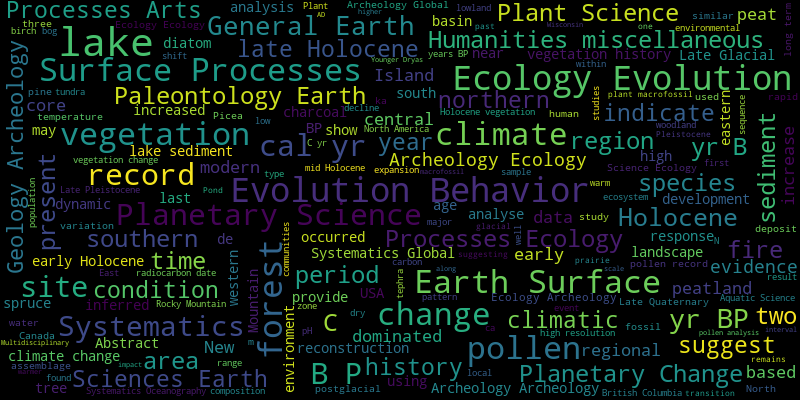

In [69]:
from wordcloud import WordCloud

pos_text = " ".join(train_df[train_df["target"] == 1]["text"].tolist())
neg_text = " ".join(train_df[train_df["target"] == 0]["text"].tolist())

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(pos_text).to_image()

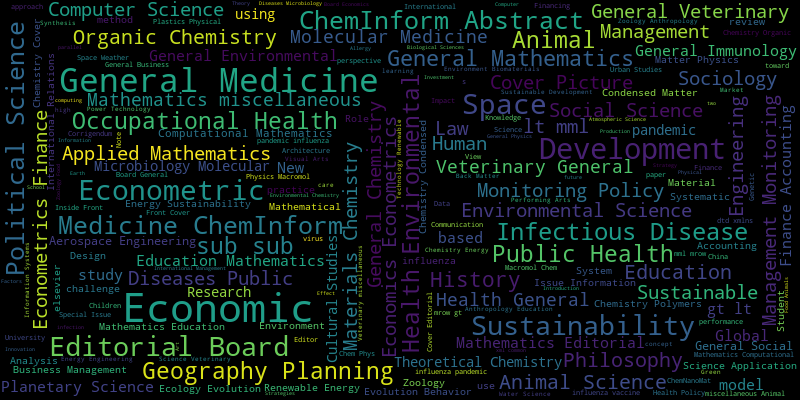

In [70]:
wordcloud.generate(neg_text).to_image()

#### Examine class distribution in train split

In [82]:
train_df["target"].value_counts(normalize=True)

0    0.694199
1    0.305801
Name: target, dtype: float64

## 5. Baseline Modelling

In [71]:
train_df.columns

Index(['container-title', 'is-referenced-by-count', 'target', 'published_year',
       'contains_author', 'text'],
      dtype='object')

##### Split X and y

In [72]:
feature = ['container-title', 'is-referenced-by-count', 'published_year', 'contains_author', 'text']
X_train, y_train = train_df[feature], train_df["target"]
X_test, y_test = test_df[feature], test_df["target"]

#### Dummy Classifier

In [78]:
from sklearn.dummy import DummyClassifier

classification_metrics = "recall"

# Fitting the dummy model
dc = DummyClassifier() 

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results = {}

cross_val_results['dummy'] = pd.DataFrame(
    cross_validate(
        dc,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(7).T
cross_val_results['dummy']


,mean,std
fit_time,0.001107,0.000441
score_time,0.001465,0.000266
test_score,0.000000,0.000000
train_score,0.000000,0.000000


Define Pre-Processing Pipeline

In [80]:
from sklearn.compose import make_column_transformer  
from sklearn.preprocessing import OneHotEncoder, StandardScaler  

# Dividing the feature types
text_features = "text"
categorical_features = ["container-title"]
binary_feature = [ "contains_author"]
numeric_features = ["is-referenced-by-count", "published_year"]

# Transformers
binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False, dtype = int)
numeric_transformer = StandardScaler()
text_transformer = CountVectorizer(stop_words="english", max_features= 100)

# Create the column transformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (binary_transformer, binary_feature),
    (categorical_transformer, categorical_features),
    (text_transformer, text_features)
)

preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['is-referenced-by-count', 'published_year']),
                                ('onehotencoder-1',
                                 OneHotEncoder(dtype=<class 'int'>,
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['container-title']),
                                ('onehotencoder-2',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['contains_author']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'text')])

##### Check Transformed Data

In [90]:
transformed_X_train = preprocessor.fit_transform(X_train)
col_names = (numeric_features + preprocessor.named_transformers_["onehotencoder-1"].get_feature_names_out().tolist() + preprocessor.named_transformers_["onehotencoder-2"].get_feature_names_out().tolist() + preprocessor.named_transformers_["countvectorizer"].get_feature_names_out().tolist())
transformed_X_train_df = pd.DataFrame(transformed_X_train, columns = col_names)
transformed_X_train_df.head()

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,is-referenced-by-count,published_year,container-title_,container-title_ADLFI. Archéologie de la France - Informations,container-title_ARCTIC,container-title_Accounting &amp; Finance,"container-title_Acta Agriculturae Scandinavica, Section A — Animal Science",container-title_Acta Astronautica,container-title_Acta Obstetricia et Gynecologica Scandinavica,container-title_Acta Paediatrica,...,study,sub,surface,sustainability,systematics,using,vegetation,water,years,yr
0,0.621565,0.132729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0
1,-0.438431,0.485861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.438431,0.485861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.396863,0.485861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.438431,0.485861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Logistic Regression

In [92]:
from sklearn.linear_model import LogisticRegression 

# The model pipeline

logreg_model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe

classification_metrics = ["accuracy", "precision", "recall", "f1"]

cross_val_results['logreg'] = pd.DataFrame(
    cross_validate(
        logreg_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

cross_val_results['logreg']

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sp

,mean,std
fit_time,0.130,0.027
score_time,0.029,0.007
test_accuracy,0.986,0.006
train_accuracy,0.993,0.001
test_precision,0.990,0.011
train_precision,0.997,0.002
test_recall,0.963,0.017
train_recall,0.982,0.002
test_f1,0.976,0.009
train_f1,0.989,0.002


#### LogReg - Preliminary investigation on feature importance for Logistic Regression

In [96]:
model_params = logreg_model.named_steps['logisticregression'].get_params()
model_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [97]:
logreg_model.fit(X_train, y_train)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count',
                                                   'published_year']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['container-title']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['contains_author']),
                                                 ('countvectorizer',
                                                  CountVectorizer(max_features=100,
                                                                  stop_words='english'),
                                                  'text')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=123))])

In [104]:
data = {
    "coefficient": logreg_model.named_steps["logisticregression"].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        logreg_model.named_steps["logisticregression"].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

,coefficient,magnitude
late,1.839737,1.839737
lake,1.837958,1.837958
paleontology,1.725220,1.725220
surface,1.665808,1.665808
holocene,1.660415,1.660415
archeology,1.638772,1.638772
plant,1.540906,1.540906
years,1.441606,1.441606
container-title_Plains Anthropologist,1.417057,1.417057
climate,1.390625,1.390625


In [105]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

,coefficient,magnitude
space,-1.777486,1.777486
sustainability,-1.501826,1.501826
economics,-1.414084,1.414084
econometrics,-1.309902,1.309902
mathematics,-1.284200,1.284200
animal,-1.225196,1.225196
political,-1.223776,1.223776
editorial,-1.200925,1.200925
published_year,-1.047517,1.047517
container-title_Journal of Post Keynesian Economics,-1.007673,1.007673


#### LogReg - Hyperparameter Tuning for Logistic Regression

In [109]:
# from scipy.stats import loguniform, randint

# # fit the model
# logreg_model.fit(X_train, y_train)

# # get the length of the vocabulary
# vocab_len = len(  
#     logreg_model.named_steps["columntransformer"]
#     .named_transformers_["countvectorizer"]
#     .get_feature_names_out()
# )
# # create a distribution of the parameters
# param_dist = {  
#     # "columntransformer__countvectorizer__max_features": np.arange(5000, vocab_len, 200),
#     "logisticregression__C": loguniform(1e-3, 1e3),
#     "logisticregression__class_weight": ["balanced", None],
# }

# # Perform a randomized search 
# random_search = RandomizedSearchCV(  
#     logreg_model,
#     param_distributions=param_dist,
#     n_iter=10,
#     verbose=1,
#     n_jobs=-1,
#     scoring='recall',
#     random_state=123,
# )
# random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory

### Build and Compare Multiple Models

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


results_dict = {}
models = {
		"dummy": DummyClassifier(random_state = 123),
    "decision tree": DecisionTreeClassifier(random_state=123, max_depth=200),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
}
